# Importing Necessary Libraries

- **Numpy** is used for numerical operations.
- **Pandas** is used for data manipulation and analysis.
- **Matplotlib** is used for plotting and data visualization.
- **Scipy's stats module** is used for statistical functions, including the Poisson distribution.
- **Sklearn's metrics module** is used for evaluating machine learning models.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import poisson
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Reading and Cleaning Data

To begin our analysis, we collected historical match data. Dataset that we use contains the outcomes of international football matches from the very first official match in 1872 through to 2024.

In [4]:
data = pd.read_csv('datasets/results.csv',sep=',',)
data=data[~data['home_score'].isna()]

# Understanding the Elo Ranking Dynamics

The Elo ranking system serves as a dynamic tool for assessing teams' relative skill levels based on their match performances. This system evaluates teams by adjusting their ratings after each match, taking into account wins, losses, and the strength of their opponents.

To construct our dataset, we must establish various parameters, including the weighting of each tournament in influencing the Elo rankings' adjustments.

In [8]:
# List of continental tournaments and qualifiers
continental_tournaments = ['AFC Asian Cup', 'African Cup of Nations', 'UEFA Euro', 'Copa América', 'CONCACAF Championship', 'Oceania Nations Cup']
continental_qualifiers = ['UEFA Euro qualification', 'African Cup of Nations qualification', 'AFC Asian Cup qualification', 'UEFA Nations League']

In [9]:
# Determines the K-factor based on the tournament type 
def determine_k_factor(tournament):
    k = 5
    if tournament == 'Friendly':
        k = 10
    elif tournament in continental_qualifiers:
        k = 20
    elif tournament == 'FIFA World Cup qualification':
        k = 25
    elif tournament in continental_tournaments:
        k = 40
    elif tournament == 'FIFA World Cup':
        k = 50
    return k

In [11]:
# Calculates the expected outcome of a match based on Elo ratings
def calculate_expected_result(home_rating, away_rating):
    rating_difference = home_rating - away_rating
    expected_home_win = 1 / (10 ** (-rating_difference / 400) + 1)
    return [round(expected_home_win, 3), 1 - round(expected_home_win, 3)]

# Determines the actual outcome of a match based on goals scored
def determine_actual_result(home_goals, away_goals):
    if home_goals > away_goals:
        return [1, 0]
    elif home_goals < away_goals:
        return [0, 1]
    else:
        return [0.5, 0.5]

# Computes updated Elo ratings after a match
def compute_elo_ratings(home_elo, away_elo, home_goals, away_goals, tournament):
    k = determine_k_factor(tournament)
    actual_home, actual_away = determine_actual_result(home_goals, away_goals)
    expected_home, expected_away = calculate_expected_result(home_elo, away_elo)

    updated_home_elo = home_elo + k * (actual_home - expected_home)
    updated_away_elo = away_elo + k * (actual_away - expected_away)

    return updated_home_elo, updated_away_elo, expected_home, expected_away


In [12]:
# Initialize dictionary to store current Elo ratings for each team
current_elo_ratings = {}

# Loop through each match in the dataset 'data'
for index, match in data.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_goals = match['home_score']
    away_goals = match['away_score']
    tournament_type = match['tournament']

    # Initialize Elo rating for each team if not already in dictionary
    if home_team not in current_elo_ratings:
        current_elo_ratings[home_team] = 1300
    if away_team not in current_elo_ratings:
        current_elo_ratings[away_team] = 1300

    # Retrieve current Elo ratings for home and away teams
    home_elo = current_elo_ratings[home_team]
    away_elo = current_elo_ratings[away_team]

    # Compute updated Elo ratings after the match
    updated_home_elo, updated_away_elo, prob_home_win, prob_away_win = compute_elo_ratings(home_elo, away_elo, home_goals, away_goals, tournament_type)

    # Update Elo ratings in the dictionary for future matches
    current_elo_ratings[home_team] = updated_home_elo
    current_elo_ratings[away_team] = updated_away_elo

    # Update DataFrame 'data' with Elo ratings and probabilities
    data.loc[index, 'Elo_h_after'] = updated_home_elo
    data.loc[index, 'Elo_a_after'] = updated_away_elo
    data.loc[index, 'Elo_h_before'] = home_elo
    data.loc[index, 'Elo_a_before'] = away_elo
    data.loc[index, 'probH'] = prob_home_win
    data.loc[index, 'probA'] = prob_away_win

In [13]:
# Combine Elo ratings for home and away teams into a single DataFrame
elo_ratings = pd.concat([
    data[['date', 'home_team', 'Elo_h_after']].rename(columns={'home_team': 'Team', 'Elo_h_after': 'Elo'}),
    data[['date', 'away_team', 'Elo_a_after']].rename(columns={'away_team': 'Team', 'Elo_a_after': 'Elo'})
])

# Sort Elo ratings by date and keep only the latest rating for each team
elo_ratings.sort_values(by='date', ascending=False, inplace=True)
elo_ratings.drop_duplicates('Team', inplace=True)

# Sort teams by Elo rating in descending order and reset index
elo_ratings.sort_values(by='Elo', ascending=False, inplace=True)
elo_ratings.reset_index(drop=True, inplace=True)
elo_ratings['Rank'] = elo_ratings.index + 1  # Add rank column

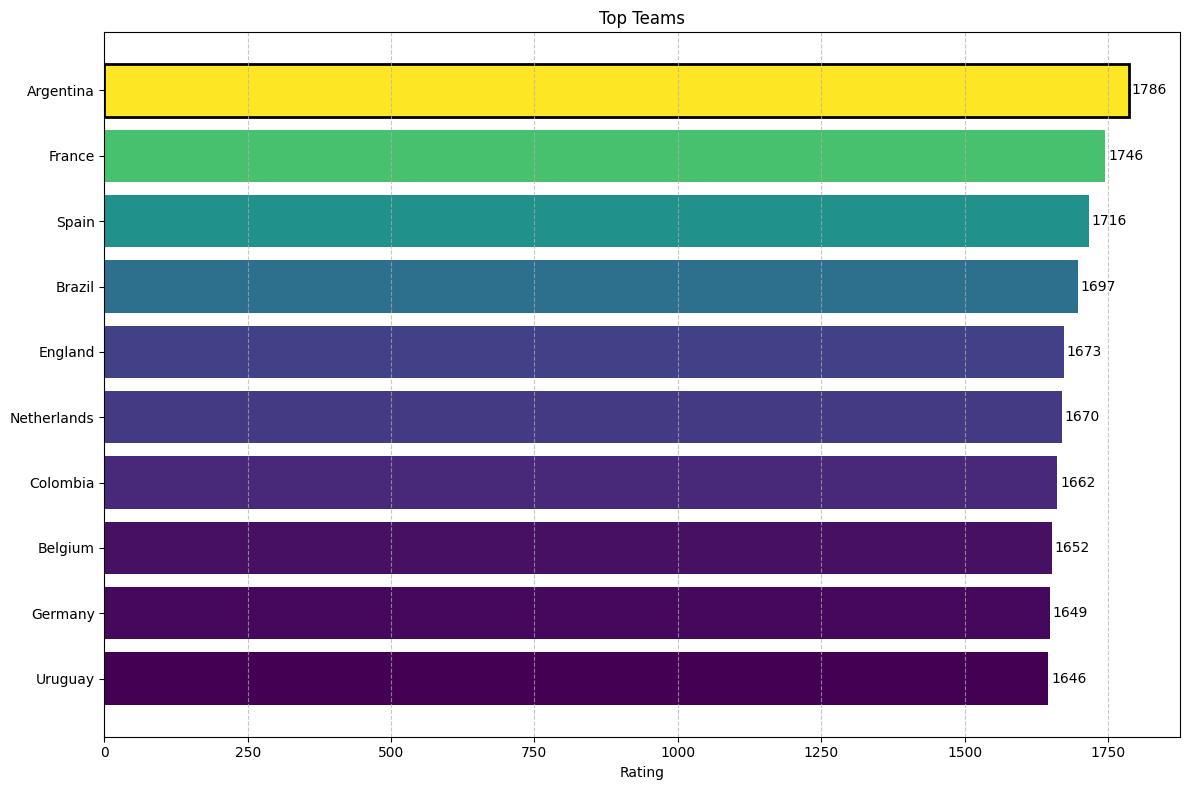

In [16]:
# Plots the top n teams by Elo rating in bar chart
def plot_top_teams(elos, n=10):
    # Sort DataFrame by Elo rating in descending order
    elos.sort_values(by='Elo', ascending=False, inplace=True)

    # Select top n teams
    top_teams = elos.head(n)

    # Define color map and normalize Elo ratings for color gradient
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=min(top_teams['Elo']), vmax=max(top_teams['Elo']))
    colors = cmap(norm(top_teams['Elo']))

    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams['Team'], top_teams['Elo'], color=colors)
    
    # Add Elo rating annotations
    for bar in bars:
        plt.text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.0f}', 
            ha='left', 
            va='center',
            fontsize=10
        )

    # Highlight the top-ranked team
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)

    # Customize plot labels and appearance
    plt.xlabel('Rating')
    plt.title('Top Teams')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest Elo at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Display plot
    plt.tight_layout()
    plt.show()

# Visualize top 10 teams overall
plot_top_teams(elo_ratings, 10)

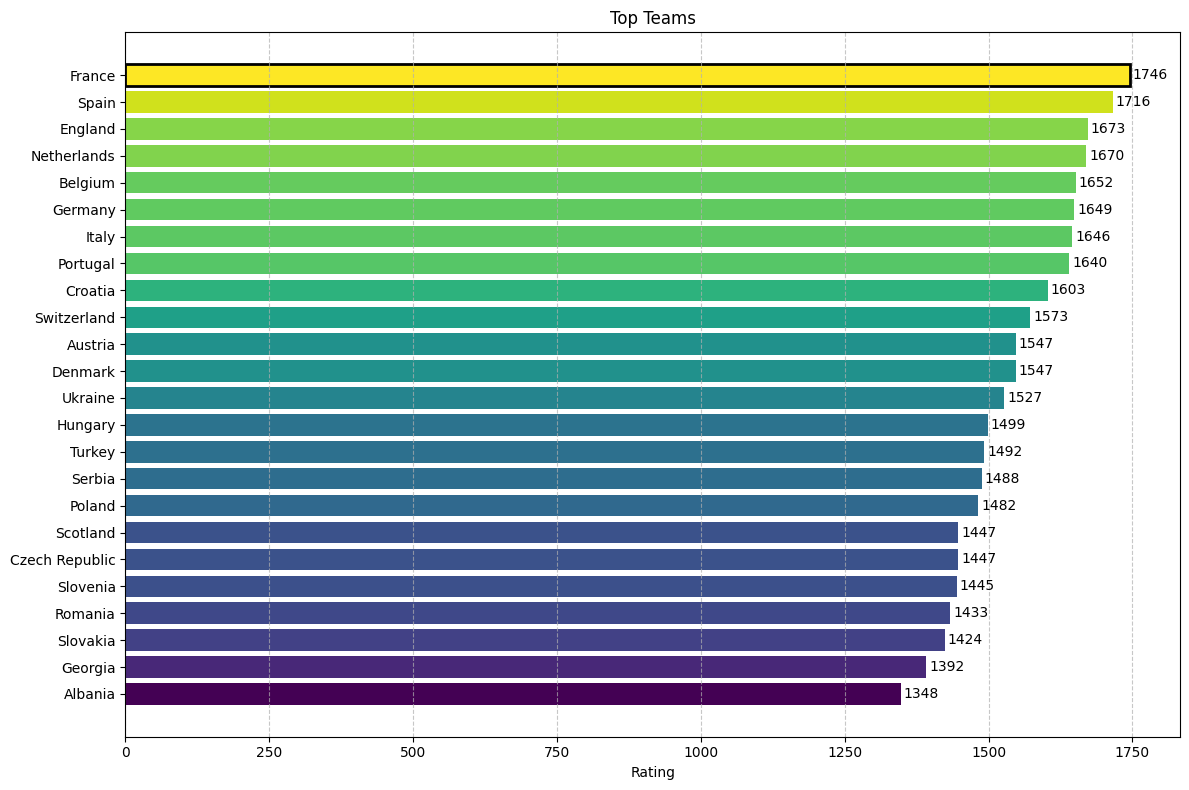

In [17]:
# Filter teams participating in Euro 2024 and visualize their Elo ratings
eurocup_teams = [
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

euro_teams_elo = elo_ratings[elo_ratings['Team'].isin(eurocup_teams)].copy()
plot_top_teams(euro_teams_elo, 24)  # Visualize top 24 teams participating in Euro 2024

# Understanding Team Performance Metrics

In addition to Elo ratings, we can enhance our analysis by introducing metrics for attacking and defensive capabilities. This approach helps in evaluating teams beyond match outcomes, considering their offensive and defensive strengths relative to opponents.

In [18]:
# Calculate updated attacking and defensive ratings after a match
def calculate_attdef(Attack_l, Attack_v, Deffend_l, Deffend_v, localGoals, awayGoals, tournament, neutral):
    k = determine_k_factor(tournament)  # Calculate the k-value based on the tournament type
    if not neutral:
        c = 1.27  # Home advantage factor
    else:
        c = 1

    # Calculate expected goals based on current ratings
    expected_home_goals = Attack_l * Deffend_v * c
    expected_away_goals = Attack_v * Deffend_l / c

    # Update ratings based on match outcome
    Attack_ln = Attack_l + (k / 2000) * (localGoals - expected_home_goals)
    Attack_vn = Attack_v + (k / 2000) * (awayGoals - expected_away_goals)
    Deffend_ln = Deffend_l + (k / 2000) * (awayGoals - expected_away_goals)
    Deffend_vn = Deffend_v + (k / 2000) * (localGoals - expected_home_goals)

    return Attack_ln, Attack_vn, Deffend_ln, Deffend_vn, expected_home_goals, expected_away_goals

Updating Team Ratings and DataFrame

In [19]:
# Initialize dictionaries to store current attacking and defensive ratings
current_att = {}
current_def = {}

# Iterate through each match in the DataFrame 'data'
for idx, row in data.iterrows():
    local = row['home_team']
    away = row['away_team']
    local_goals = row['home_score']
    away_goals = row['away_score']
    tournament = row['tournament']
    neutral = row['neutral']

    # Initialize ratings if the team is not in dictionaries
    if local not in current_att:
        current_att[local] = 1.3
    if away not in current_att:
        current_att[away] = 1.3
    if local not in current_def:
        current_def[local] = 1.3
    if away not in current_def:
        current_def[away] = 1.3

    # Retrieve current ratings
    att_l = current_att[local]
    att_v = current_att[away]
    def_l = current_def[local]
    def_v = current_def[away]

    # Calculate updated ratings and expected goals
    att_ln, att_vn, def_ln, def_vn, ehg, eag = calculate_attdef(att_l, att_v, def_l, def_v, local_goals, away_goals, tournament, neutral)

    # Update dictionaries with new ratings
    current_att[local] = att_ln
    current_att[away] = att_vn
    current_def[local] = def_ln
    current_def[away] = def_v

    # Update DataFrame 'data' with new ratings and expected goals
    data.loc[idx, 'att_h_after'] = att_ln
    data.loc[idx, 'att_a_after'] = att_vn
    data.loc[idx, 'att_h_before'] = att_l
    data.loc[idx, 'att_a_before'] = att_v
    data.loc[idx, 'def_h_after'] = def_ln
    data.loc[idx, 'def_a_after'] = def_vn
    data.loc[idx, 'def_h_before'] = def_l
    data.loc[idx, 'def_a_before'] = def_v
    data.loc[idx, 'XGhome'] = ehg
    data.loc[idx, 'XGaway'] = eag

Creating Team Ratings DataFrame

In [20]:
# Create a DataFrame 'attdef' containing updated attacking and defensive ratings
attdef = pd.concat([
    data[['date', 'home_team', 'att_h_after', 'def_h_after']].rename(columns={'home_team': 'Team', 'att_h_after': 'att', 'def_h_after': 'def'}),
    data[['date', 'away_team', 'att_a_after', 'def_a_after']].rename(columns={'away_team': 'Team', 'att_a_after': 'att', 'def_a_after': 'def'})
])
attdef.sort_values(by='date', ascending=False, inplace=True)
attdef.drop_duplicates('Team', inplace=True)
attdef.sort_values(by='def', ascending=True, inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['def_position'] = attdef.index + 1
attdef.sort_values(by='att', ascending=False, inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['att_position'] = attdef.index + 1

Plotting Top Teams by Attacking and Defensive Ratings

In [23]:
# Function to plot top teams by attacking and defensive ratings
def plot_top_att_def(elos, n=10):
    # Sort DataFrame by attacking and defensive ratings
    elos_sorted_att = elos.sort_values(by='att', ascending=False).head(n)
    elos_sorted_def = elos.sort_values(by='def', ascending=True).head(n)

    # Create color map for both plots
    colors_att = plt.cm.viridis(elos_sorted_att['att'] / max(elos_sorted_att['att']))
    colors_def = plt.cm.viridis(elos_sorted_def['def'] / max(elos_sorted_def['def']))

    # Create subplots for attacking and defensive ratings
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for attacking ratings
    bars_att = ax1.barh(elos_sorted_att['Team'], elos_sorted_att['att'], color=colors_att)
    ax1.set_title('Top Teams - Attacking Power', fontsize=16, weight='bold')
    ax1.invert_yaxis()  # Invert y-axis to display highest rating at the top
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for attacking ratings
    for bar in bars_att:
        ax1.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Plot for defensive ratings
    bars_def = ax2.barh(elos_sorted_def['Team'], elos_sorted_def['def'], color=colors_def)
    ax2.set_title('Top Teams - Defensive Power', fontsize=16, weight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for defensive ratings
    for bar in bars_def:
        ax2.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

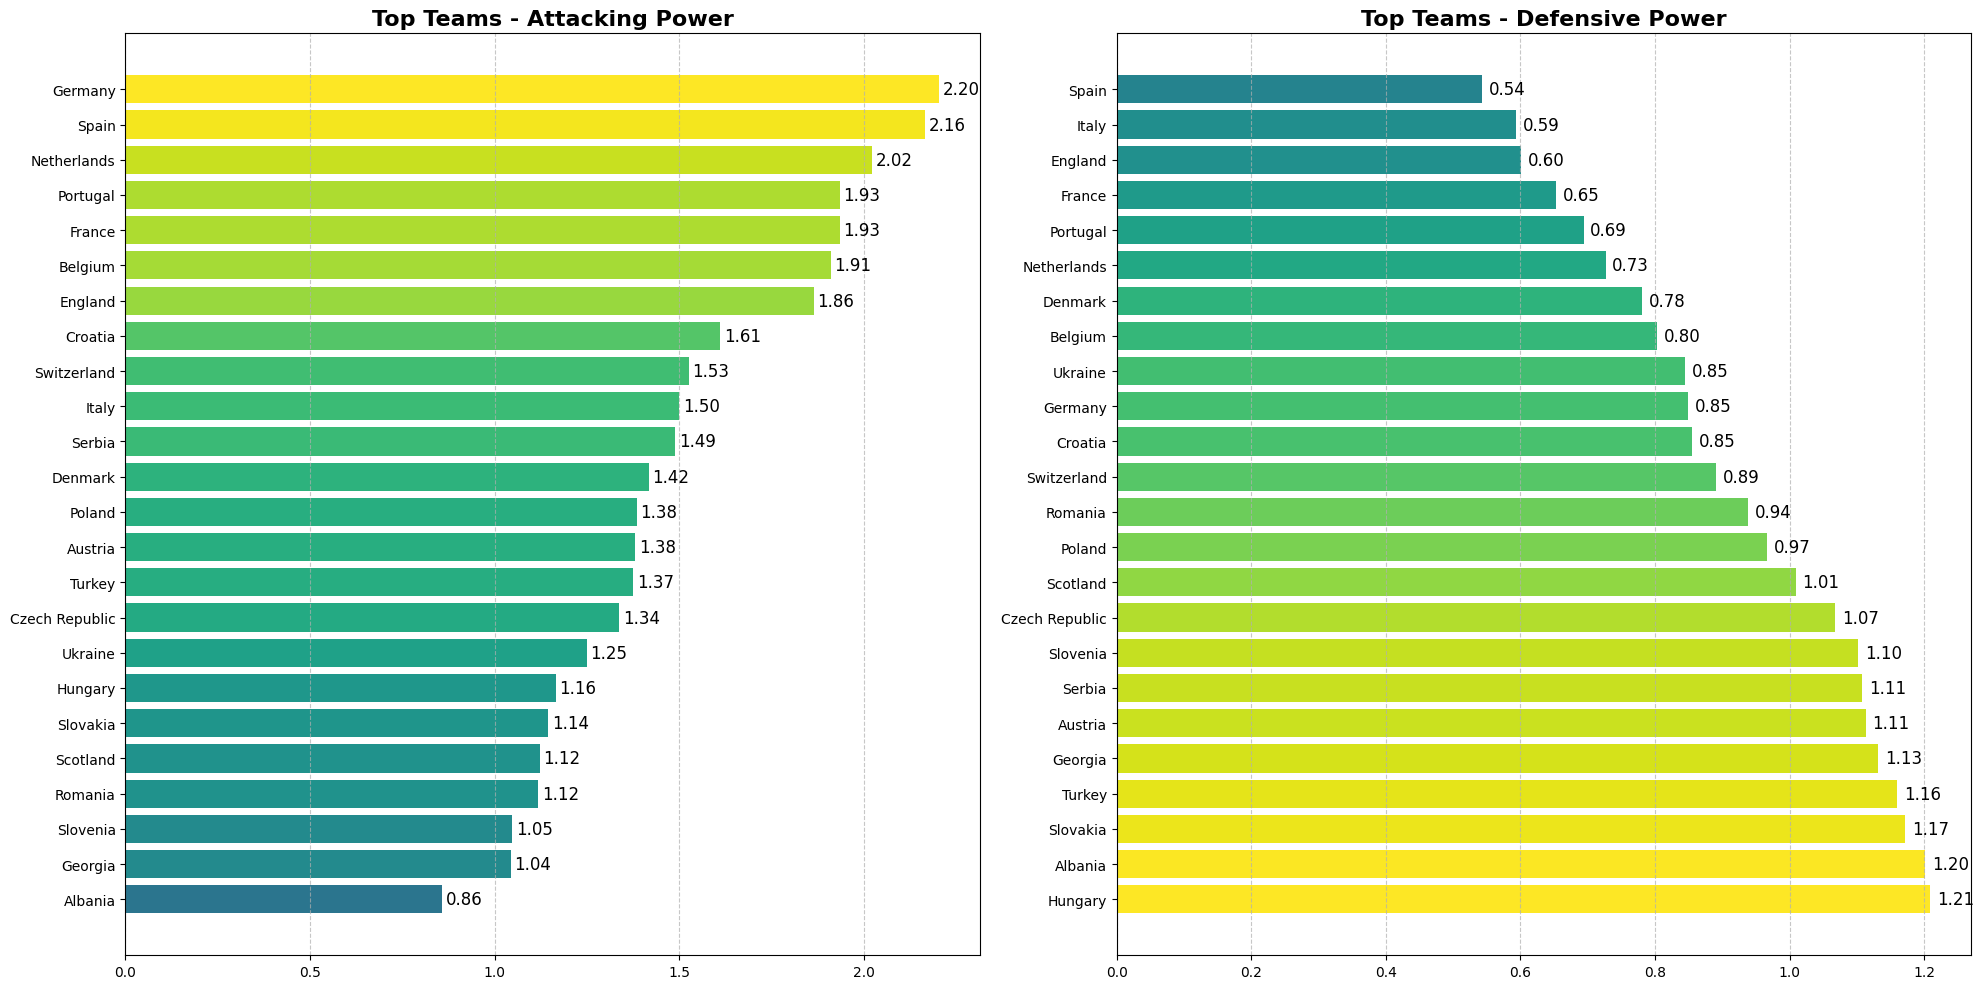

In [24]:
# Plotting top teams by attacking and defensive ratings for Euro 2024 teams
attdef_ranking_europe = attdef[attdef.Team.isin(eurocup_teams)]
plot_top_att_def(attdef_ranking_europe, 24)